In [ ]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# machine learning modules
from sklearn.metrics import mean_squared_error
%tensorflow_version 2.x
import tensorflow as tf

# apparently this is needed to read in the datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
tf.__version__

'2.9.2'

In [ ]:
data_url = 'https://raw.githubusercontent.com/yuempark/SFO-weather-prediction/master/SFO-weather.csv?token=ADI6VJ4TLL2SDMTMW7JUXXS6JXQWI'

data = pd.read_csv(data_url)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27213 entries, 0 to 27212
Data columns (total 90 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          27213 non-null  object 
 1   NAME             27213 non-null  object 
 2   LATITUDE         27213 non-null  float64
 3   LONGITUDE        27213 non-null  float64
 4   ELEVATION        27213 non-null  float64
 5   DATE             27213 non-null  object 
 6   ACMH             11585 non-null  float64
 7   ACMH_ATTRIBUTES  11585 non-null  object 
 8   ACSH             11590 non-null  float64
 9   ACSH_ATTRIBUTES  11590 non-null  object 
 10  AWND             13187 non-null  float64
 11  AWND_ATTRIBUTES  13187 non-null  object 
 12  FMTM             10182 non-null  float64
 13  FMTM_ATTRIBUTES  10182 non-null  object 
 14  FRGT             3 non-null      float64
 15  FRGT_ATTRIBUTES  3 non-null      object 
 16  PGTM             22521 non-null  float64
 17  PGTM_ATTRIBU

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,9,11,13,15,25,31,33,35,37,39,41,43,45,47,49,51,53,61,65,69,71,73,75,77,81,83,85,87,89) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
del_cols = []

for i in range(len(data.columns)):
    if np.sum(~pd.isnull(data[data.columns[i]])) < 5000:
        del_cols.append(data.columns[i])

data.drop(del_cols, axis=1, inplace=True)

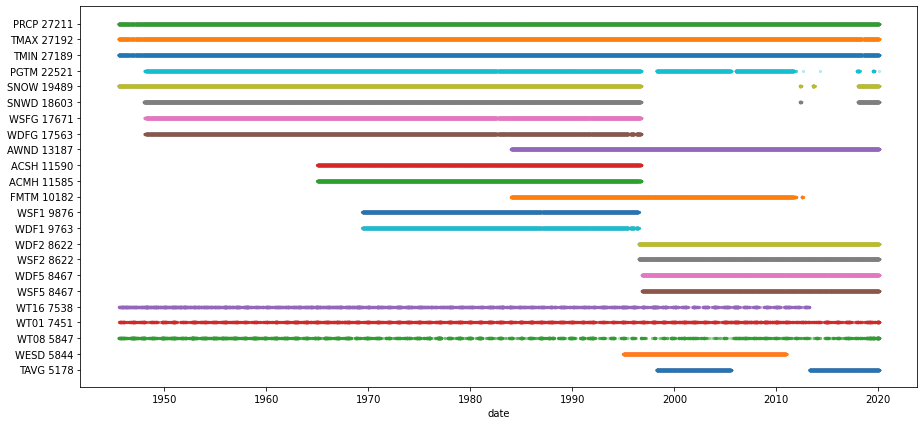

In [ ]:
# convert the date column to datetime
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')

# pull out the time series data, and ignore the attribute columns for now
feature_cols = []
for i in range(6, len(data.columns)):
    if 'ATTRIBUTES' not in data.columns[i]:
        feature_cols.append(data.columns[i])

# sort these features by number of non-null cells
n_non_null = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
    n_non_null[i] = np.sum(~pd.isnull(data[feature_cols[i]]))
non_null_sort_inds = np.argsort(n_non_null)
n_non_null = n_non_null[non_null_sort_inds]
feature_cols[:] = [feature_cols[i] for i in non_null_sort_inds]

fig, ax = plt.subplots(figsize=(15,7))
yticklabels = []

# iterate through the feature columns
for i in range(len(feature_cols)):

    # create a simple data present/not present mask
    data_mask_bool = ~pd.isnull(data[feature_cols[i]])
    data_mask_int = np.zeros(len(data_mask_bool))
    data_mask_int[data_mask_bool] = 1
    data_mask_int[~data_mask_bool] = np.nan

    # plot it
    ax.scatter(data['DATE'], data_mask_int+i-1, alpha=0.25, s=5)

    yticklabels.append(feature_cols[i] + ' ' + str(int(n_non_null[i])))

# prettify
ax.set_xlabel('date')
ax.set_yticks(range(len(feature_cols)))
ax.set_yticklabels(yticklabels)

plt.show(fig)

In [ ]:
# select the features based on the figure above
features = ['PRCP','TMAX','TMIN','AWND','WDF2','WSF2','WDF5','WSF5','WT01','WT08']
attributes = ['DATE','PRCP_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','AWND_ATTRIBUTES',
              'WDF2_ATTRIBUTES','WSF2_ATTRIBUTES','WDF5_ATTRIBUTES','WSF5_ATTRIBUTES','WT01_ATTRIBUTES','WT08_ATTRIBUTES']
data_features = data[features].copy()
data_attributes = data[attributes].copy()

# find where the data starts for WDF5 (the feature that starts the latest)
start_date = np.min(data_attributes[~pd.isnull(data_features['WDF5'])]['DATE'])

# slice the data
data_features = data_features[data_attributes['DATE']>=start_date]
data_attributes = data_attributes[data_attributes['DATE']>=start_date]

# there are no observations for the last day of the dataset
data_features.drop(data_features.tail(1).index, axis=0, inplace=True)
data_attributes.drop(data_attributes.tail(1).index, axis=0, inplace=True)

# reset indexes
data_features.reset_index(drop=True, inplace=True)
data_attributes.reset_index(drop=True, inplace=True)

# change nan's to zeros in the fog and smoke features
data_features.loc[np.isnan(data_features['WT01']), 'WT01'] = 0
data_features.loc[np.isnan(data_features['WT08']), 'WT08'] = 0

# in the attributes columns, the second value is the quality flag
# any value here indicates that the measurement failed a quality assurance check, so let's get rid of them
bad_observations = []
for i in range(len(data_features)):
    for j in range(len(features)):
        if type(data_attributes[features[j]+'_ATTRIBUTES'][i])==str:
            if len(data_attributes[features[j]+'_ATTRIBUTES'][i].split(',')[1]) != 0:
                data_features[features[j]][i] = np.nan
                bad_observations.append('{},'.format(i) + features[j])
print(bad_observations)

['365,WSF2', '2310,AWND']


In [ ]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRCP    8500 non-null   float64
 1   TMAX    8480 non-null   float64
 2   TMIN    8480 non-null   float64
 3   AWND    8498 non-null   float64
 4   WDF2    8499 non-null   float64
 5   WSF2    8498 non-null   float64
 6   WDF5    8467 non-null   float64
 7   WSF5    8467 non-null   float64
 8   WT01    8500 non-null   float64
 9   WT08    8500 non-null   float64
dtypes: float64(10)
memory usage: 664.2 KB


In [ ]:
# the columns and methods for imputing
impute_cols = ['TMAX','TMIN','AWND','WDF2','WSF2','WDF5','WSF5']
impute_methods = ['pad','linear','akima','cubic']
impute_col_methods = []
for col in impute_cols:
    for method in impute_methods:
        impute_col_methods.append(col + '_' + method)

# set up a dataframe to store our results
n_remove_inds = 50
n_folds = 1000
np.random.seed(2020)
impute_cv_results = pd.DataFrame(columns=impute_col_methods, index=np.arange(n_folds), dtype=float)

# iterate through the folds
for i in range(n_folds):

    # iterate through the columns
    for col in impute_cols:

        # randomly pick values to remove, avoiding the edges of the data to avoid extrapolation issues
        remove_inds = np.random.choice(np.arange(1, len(data_features)-1), size=n_remove_inds, replace=False)
        fake_col = data_features[col].copy()
        fake_col[remove_inds] = np.nan

        # impute using various methods
        fake_col_pad = fake_col.interpolate(method='pad')
        fake_col_linear = fake_col.interpolate(method='linear')
        fake_col_akima = fake_col.interpolate(method='akima')
        fake_col_cubic = fake_col.interpolate(method='cubic')

        # the original data that was removed
        imputed_label = data_features[col][remove_inds]
        # the values that were imputed
        imputed_prediction_pad = fake_col_pad[remove_inds]
        imputed_prediction_linear = fake_col_linear[remove_inds]
        imputed_prediction_akima = fake_col_akima[remove_inds]
        imputed_prediction_cubic = fake_col_cubic[remove_inds]

        # we might have accidentally picked some NaNs in the real data - get rid of them
        imputed_prediction_pad = imputed_prediction_pad[np.isfinite(imputed_label)]
        imputed_prediction_linear = imputed_prediction_linear[np.isfinite(imputed_label)]
        imputed_prediction_akima = imputed_prediction_akima[np.isfinite(imputed_label)]
        imputed_prediction_cubic = imputed_prediction_cubic[np.isfinite(imputed_label)]
        imputed_label = imputed_label[np.isfinite(imputed_label)]

        # compute the RMSE's and store
        impute_cv_results[col + '_pad'][i] = mean_squared_error(imputed_label, imputed_prediction_pad, squared=False)
        impute_cv_results[col + '_linear'][i] = mean_squared_error(imputed_label, imputed_prediction_linear, squared=False)
        impute_cv_results[col + '_akima'][i] = mean_squared_error(imputed_label, imputed_prediction_akima, squared=False)
        impute_cv_results[col + '_cubic'][i] = mean_squared_error(imputed_label, imputed_prediction_cubic, squared=False)

impute_cv_results.describe()

,TMAX_pad,TMAX_linear,TMAX_akima,TMAX_cubic,TMIN_pad,TMIN_linear,TMIN_akima,TMIN_cubic,AWND_pad,AWND_linear,...,WSF2_akima,WSF2_cubic,WDF5_pad,WDF5_linear,WDF5_akima,WDF5_cubic,WSF5_pad,WSF5_linear,WSF5_akima,WSF5_cubic
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.789044,2.073185,2.086859,2.247850,1.602559,1.223943,1.251419,1.374636,1.752017,1.362209,...,2.601549,2.953818,71.891666,60.841093,62.587716,73.621095,3.871261,3.130027,3.226898,3.661417
std,0.396672,0.273464,0.276424,0.286188,0.195566,0.156918,0.159858,0.173645,0.235555,0.192932,...,0.449819,0.502344,14.789341,12.225603,12.808845,14.645357,0.563990,0.462030,0.475353,0.509598
min,1.472815,1.238023,1.286542,1.415079,0.935094,0.766290,0.825409,0.818154,1.070701,0.841309,...,1.563115,1.703735,27.166155,23.558438,24.592915,27.065663,2.468413,1.966323,2.034372,2.225093
25%,2.499948,1.887084,1.897441,2.053081,1.460342,1.109392,1.136670,1.250645,1.593016,1.231523,...,2.319933,2.623713,61.510161,51.940038,53.513153,63.317525,3.477564,2.789215,2.894054,3.288450
50%,2.770866,2.077829,2.090437,2.234273,1.593267,1.220738,1.251536,1.368028,1.736951,1.345019,...,2.553986,2.909377,71.851462,60.658195,62.228249,73.419637,3.829896,3.102866,3.196308,3.645532
75%,3.049156,2.258761,2.274709,2.432357,1.743187,1.325271,1.353468,1.494689,1.898473,1.486555,...,2.828005,3.184817,81.847413,69.335224,71.471889,83.131143,4.238165,3.429768,3.553416,3.985154
max,4.200714,3.087629,3.035313,3.295175,2.244638,1.708040,1.849058,1.947835,2.593183,2.109606,...,6.004858,6.249596,120.016666,100.604285,102.213956,119.234024,5.993179,4.793098,4.863906,5.495756


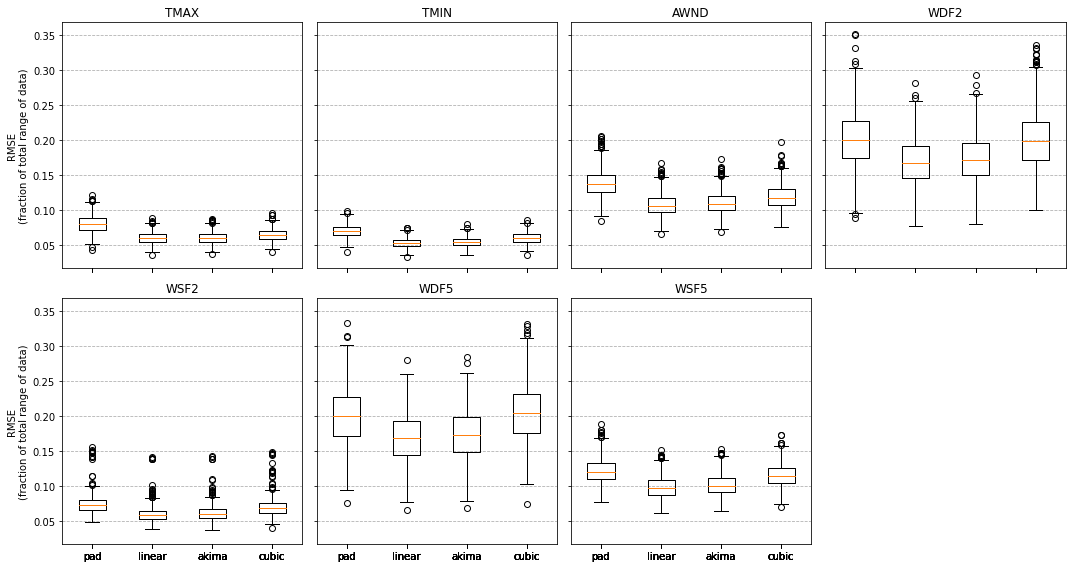

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(15,8), sharex=True, sharey=True)

ax = ax.flatten()

for i in range(len(impute_cols)):
    data_range = np.nanmax(data_features[impute_cols[i]]) - np.nanmin(data_features[impute_cols[i]])
    ax[i].boxplot([impute_cv_results[impute_cols[i]+'_pad']/data_range,
                   impute_cv_results[impute_cols[i]+'_linear']/data_range,
                   impute_cv_results[impute_cols[i]+'_akima']/data_range,
                   impute_cv_results[impute_cols[i]+'_cubic']/data_range],
                  labels=impute_methods)
    ax[i].set_title(impute_cols[i])
    ax[i].yaxis.grid(ls='--')

ax[7].set_axis_off()

ax[0].set_ylabel('RMSE\n(fraction of total range of data)')
ax[4].set_ylabel('RMSE\n(fraction of total range of data)')

fig.tight_layout()
plt.show(fig)

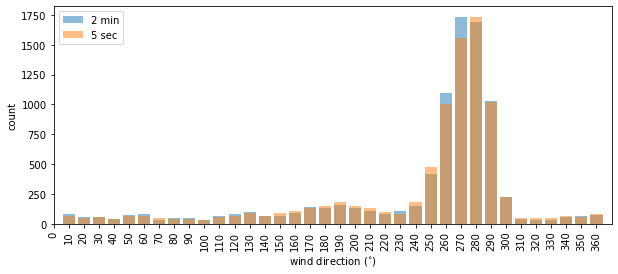

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

WDF2_directions, WDF2_counts = np.unique(data_features['WDF2'], return_counts=True)
WDF5_directions, WDF5_counts = np.unique(data_features['WDF5'], return_counts=True)

ax.bar(np.arange(len(WDF2_directions)-1), WDF2_counts[:-1], color='C0', alpha=0.5, label='2 min')
ax.bar(np.arange(len(WDF5_directions)-1), WDF5_counts[:-1], color='C1', alpha=0.5, label='5 sec')

ax.set_xlabel('wind direction ($^{\circ}$)')
ax.set_ylabel('count')
ax.legend(loc='upper left')
ax.set_xlim(0,len(WDF2_directions)-1)
ax.set_xticks(np.arange(len(WDF2_directions)-1))
ax.set_xticklabels(WDF2_directions[:-1].astype(int), rotation=90)

plt.show(fig)

In [ ]:
data_features_imputed = data_features.copy()

# perform the simple linear interpolations for temperature and wind speed features
for feature in ['TMAX','TMIN','AWND','WSF2','WSF5']:
    data_features_imputed[feature] = data_features_imputed[feature].interpolate(method='linear')

# manually perform the linear interpolation for the wind direction features
for i in range(len(data_features_imputed)):

    for feature in ['WDF2','WDF5']:

        # find the missing values
        if np.isnan(data_features_imputed[feature][i]):

            # find the next non-NaN value
            next_ind = i + 1
            while np.isnan(data_features_imputed[feature][next_ind]):
                next_ind = next_ind + 1

            # get the values on either side
            left_val = data_features_imputed[feature][i-1]
            right_val = data_features_imputed[feature][next_ind]

            # if the change in direction is more than 180 degrees,
            # it's not representing the smallest angle between the two directions
            if abs(right_val-left_val)>180:
                if left_val < right_val:
                    left_val = left_val + 360
                else:
                    right_val = right_val + 360

            # compute the interpolated value, and put it in the 0-360 range
            impute_val = left_val + ((right_val-left_val) / (next_ind-i+1))
            impute_val = impute_val % 360

            # impute
            data_features_imputed[feature][i] = impute_val

data_features_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRCP    8500 non-null   float64
 1   TMAX    8500 non-null   float64
 2   TMIN    8500 non-null   float64
 3   AWND    8500 non-null   float64
 4   WDF2    8500 non-null   float64
 5   WSF2    8500 non-null   float64
 6   WDF5    8500 non-null   float64
 7   WSF5    8500 non-null   float64
 8   WT01    8500 non-null   float64
 9   WT08    8500 non-null   float64
dtypes: float64(10)
memory usage: 664.2 KB


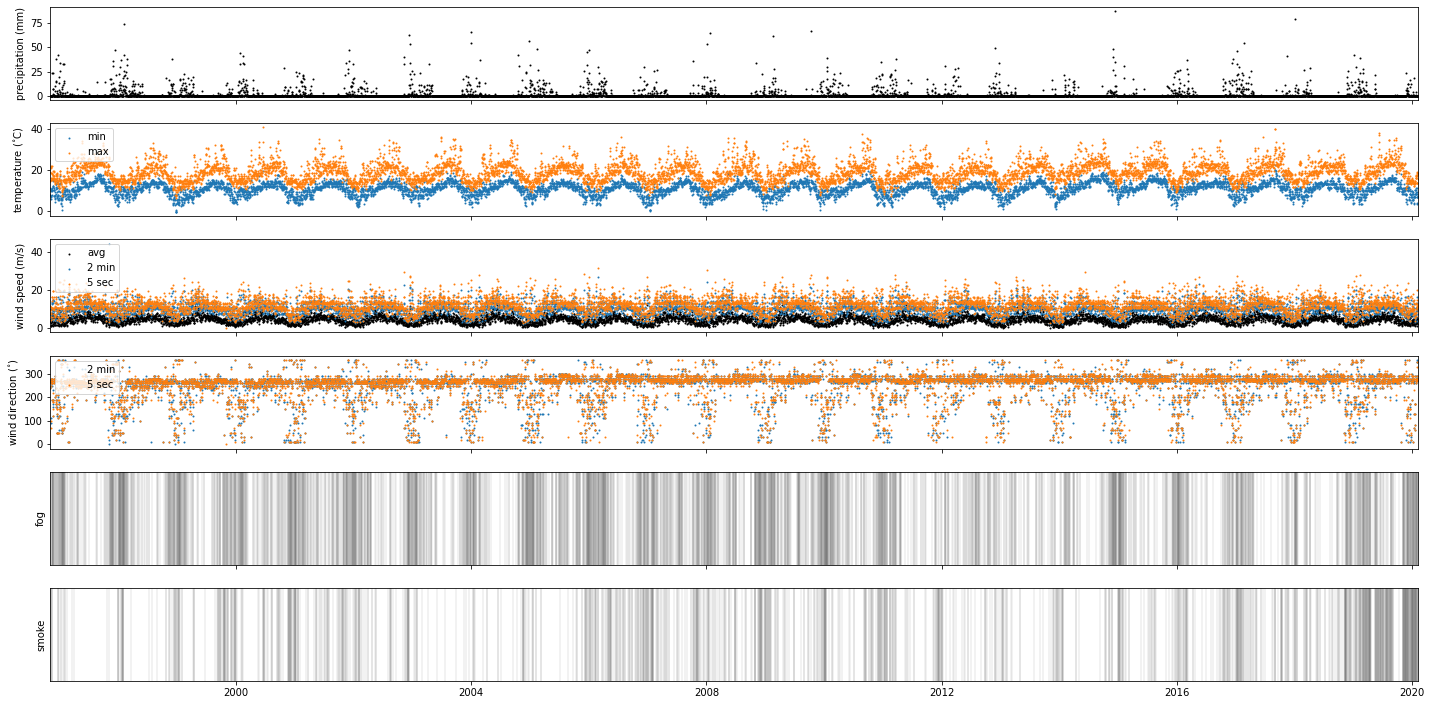

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=6, figsize=(20,10), sharex=True)

s = 1
lw = 0.1

ax[0].scatter(data_attributes['DATE'], data_features_imputed['PRCP'], c='k', s=s)
ax[0].set_ylabel('precipitation (mm)')

ax[1].scatter(data_attributes['DATE'], data_features_imputed['TMIN'], c='C0', s=s, label='min')
ax[1].scatter(data_attributes['DATE'], data_features_imputed['TMAX'], c='C1', s=s, label='max')
ax[1].set_ylabel('temperature ($^{\circ}$C)')
ax[1].legend(loc='upper left')

ax[2].scatter(data_attributes['DATE'], data_features_imputed['AWND'], c='k', s=s, label='avg')
ax[2].scatter(data_attributes['DATE'], data_features_imputed['WSF2'], c='C0', s=s, label='2 min')
ax[2].scatter(data_attributes['DATE'], data_features_imputed['WSF5'], c='C1', s=s, label='5 sec')
ax[2].set_ylabel('wind speed (m/s)')
ax[2].legend(loc='upper left')

ax[3].scatter(data_attributes['DATE'], data_features_imputed['WDF2'], c='C0', s=s, label='2 min')
ax[3].scatter(data_attributes['DATE'], data_features_imputed['WDF5'], c='C1', s=s, label='5 sec')
ax[3].set_ylabel('wind direction ($^{\circ}$)')
ax[3].legend(loc='upper left')

for date in data_attributes[data_features_imputed['WT01']==1]['DATE']:
    ax[4].axvline(date, c='k', lw=0.1)
ax[4].set_ylabel('fog')
ax[4].set_yticks([])

for date in data_attributes[data_features_imputed['WT08']==1]['DATE']:
    ax[5].axvline(date, c='k', lw=0.1)
ax[5].set_ylabel('smoke')
ax[5].set_yticks([])

ax[5].set_xlim(np.min(data_attributes['DATE']), np.max(data_attributes['DATE']))

fig.tight_layout()
plt.show(fig)

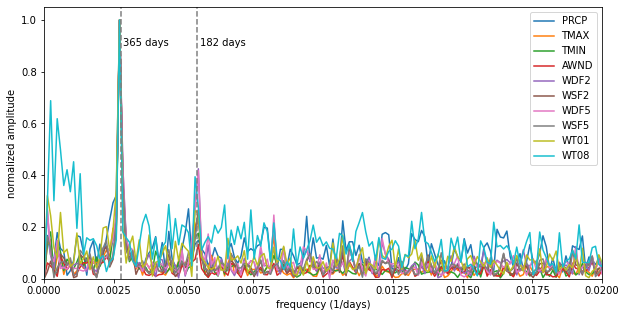

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

for feature in features:

    # subtract the mean from the data and taper it
    tukey = signal.tukey(len(data_features_imputed[feature]))
    tapered_data = (data_features_imputed[feature] - np.mean(data_features_imputed[feature])) * tukey

    # perform the fft
    yf = np.fft.rfft(data_features_imputed[feature] - np.mean(data_features_imputed[feature]))
    xf = np.fft.rfftfreq(len(data_features_imputed[feature]))

    # plot the amplitude, but in wavelength space instead of frequency
    ax.plot(xf, abs(yf)/np.max(abs(yf)), label=feature)

# plot markers for wavelengths of 182 and 365 days
ax.axvline(1/365, ls='--', c='C7')
ax.axvline(1/182, ls='--', c='C7')
ax.text(1/365 + 0.0001, 0.9, '365 days')
ax.text(1/182 + 0.0001, 0.9, '182 days')

ax.set_xlabel('frequency (1/days)')
ax.set_ylabel('normalized amplitude')
ax.set_xlim(0,0.02)
ax.set_ylim(0,1.05)
ax.legend()

plt.show()

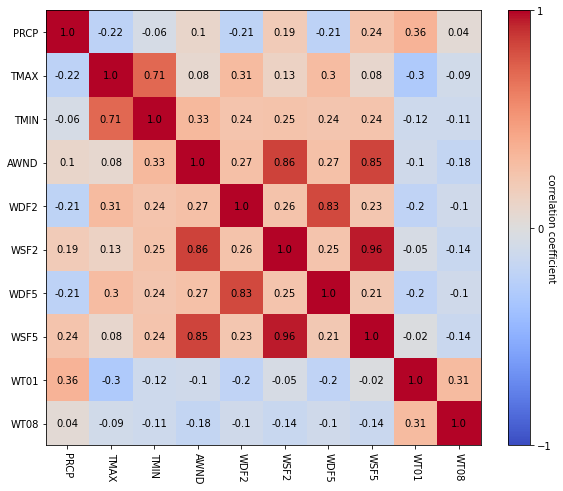

In [ ]:
# calculate the correlation matrix
corr_mtx = np.corrcoef(np.transpose(data_features_imputed.values))

fig, ax = plt.subplots(figsize=(10,8))

# plot the colours
cax = ax.imshow(corr_mtx, vmin=-1, vmax=1, cmap='coolwarm')

# set the axis labels
ax.set_xticks(np.arange(0,len(data_features_imputed.columns)))
ax.set_yticks(np.arange(0,len(data_features_imputed.columns)))
ax.set_xticklabels(data_features_imputed.columns, rotation=270)
ax.set_yticklabels(data_features_imputed.columns)

# add the colorbar
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_ylabel('correlation coefficient', rotation=270)

# add text for the values
for i in range(len(data_features_imputed.columns)):
    for j in range(len(data_features_imputed.columns)):
        ax.text(i, j, str(np.round(corr_mtx[i,j],2)),
                horizontalalignment='center', verticalalignment='center')

plt.show(fig)

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
    """
    Function modified from https://www.tensorflow.org/tutorials/structured_data/time_series

    Parameters
    ----------
    dataset : dataframe
        The dataframe which contains the observations.

    target : series
        The series which contains the target.

    start_index : int
        The index at which to start grabbing target data.

    end_index : int
        The index at which to stop grabbing target data.

    history_size : int
        The number of indexes to grab leading up to the prediction window.

    target_size : int
        The size of the prediction window.

    Returns
    -------
    data : array
        The data.

    labels : array
        The labels.
    """
    data = []
    labels = []

    if end_index is None:
        end_index = len(dataset) - target_size

    # grab successive data+label windows
    # (i is the index from which the target will be grabbed)
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
n_instances = len(data_features_imputed)

# define window sizes
history_size = 180
target_size = 30

# define the split sizes
TRAIN_SPLIT = 7000
VAL_SPLIT = 1000
TEST_SPLIT = n_instances - TRAIN_SPLIT - VAL_SPLIT - history_size - target_size

# standardize the data (using just values from the training split)
dataset = data_features_imputed.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

# extract the test split and shuffle
x_test, y_test = multivariate_data(dataset, dataset[:, 2], n_instances-target_size-TEST_SPLIT, n_instances-target_size, history_size, target_size)
p = np.random.permutation(x_test.shape[0])
x_test = x_test[p]
y_test = y_test[p]

# extract the x and y that has to be shuffled
x_shuffle, y_shuffle = multivariate_data(dataset, dataset[:, 2], history_size, n_instances-target_size-TEST_SPLIT, history_size, target_size)

# shuffle
p = np.random.permutation(x_shuffle.shape[0])
x_shuffle = x_shuffle[p]
y_shuffle = y_shuffle[p]

# make the train/validation split
x_train = x_shuffle[:TRAIN_SPLIT,:,:]
x_val = x_shuffle[TRAIN_SPLIT:,:,:]
y_train = y_shuffle[:TRAIN_SPLIT,:]
y_val = y_shuffle[TRAIN_SPLIT:,:]

print('x_train  = {}'.format(x_train.shape))
print('x_val    = {}'.format(x_val.shape))
print('x_test   = {}'.format(x_test.shape))

x_train  = (7000, 180, 10)
x_val    = (1000, 180, 10)
x_test   = (290, 180, 10)


In [ ]:
print('Single history window : {}'.format(x_train[0].shape))
print('Single target window  : {}'.format(y_train[0].shape))

Single history window : (180, 10)
Single target window  : (30,)


In [ ]:
tf.random.set_seed(2020)

BATCH_SIZE = 256

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE).repeat()

In [ ]:
def plot_instance(ax, history, target):
    """
    Function modified from https://www.tensorflow.org/tutorials/structured_data/time_series

    Parameters
    ----------
    ax : axis
        The axis on which to make the plot

    history : array_like
        The history window.

    target : array_like
        The target window.

    prediction : array_like
        The model prediction of the target window.
    """
    # make x=0 the start of the target window
    history_x = np.arange(-len(history), 0)
    target_x = np.arange(len(target))

    # plot the history window
    ax.plot(history_x,
            np.array(history[:, 2])*data_std[2]+data_mean[2],
            c='C7', label='history')

    # plot the connection between the history window and the target window
    ax.plot([history_x[-1],target_x[0]],
            np.array([np.array(history[:, 2])[-1], np.array(target)[0]])*data_std[2]+data_mean[2],
            c='k', ls='--', label='__nolegend__')

    # plot the target window
    ax.plot(target_x,
            np.array(target)*data_std[2]+data_mean[2],
            c='k', label='target')

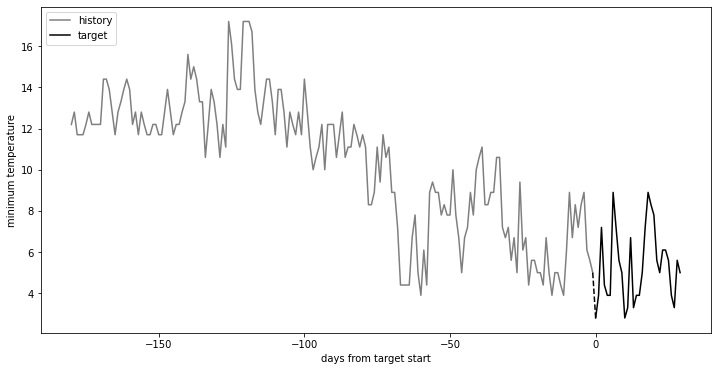

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

for x, y in train_data.take(1):
    plot_instance(ax, x[0], y[0])

ax.legend(loc='upper left')
ax.set_xlabel('days from target start')
ax.set_ylabel('minimum temperature')

plt.show(fig)

In [ ]:
model_01 = tf.keras.models.Sequential()

model_01.add(tf.keras.layers.LSTM(32, input_shape=x_train.shape[-2:], return_sequences=True))
model_01.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_01.add(tf.keras.layers.LSTM(8, activation='relu'))
model_01.add(tf.keras.layers.Dense(target_size))

model_01.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
                 loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 32)           5504      
                                                                 
 lstm_1 (LSTM)               (None, 180, 16)           3136      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 30)                270       
                                                                 
Total params: 9,710
Trainable params: 9,710
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 15
VALIDATION_STEPS = 50
EVALUATION_INTERVAL = 200

model_01_history = model_01.fit(train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=50)

Epoch 1/15
200/200 [==============================] - 83s 373ms/step - loss: 0.6477 - root_mean_squared_error: 0.8048 - val_loss: 0.4516 - val_root_mean_squared_error: 0.6720
Epoch 2/15
200/200 [==============================] - 75s 374ms/step - loss: 0.3973 - root_mean_squared_error: 0.6303 - val_loss: 0.3688 - val_root_mean_squared_error: 0.6073
Epoch 3/15
200/200 [==============================] - 74s 370ms/step - loss: 0.3542 - root_mean_squared_error: 0.5952 - val_loss: 0.3480 - val_root_mean_squared_error: 0.5899
Epoch 4/15
200/200 [==============================] - 74s 368ms/step - loss: 0.3366 - root_mean_squared_error: 0.5802 - val_loss: 0.3299 - val_root_mean_squared_error: 0.5744
Epoch 5/15
200/200 [==============================] - 73s 368ms/step - loss: 0.3243 - root_mean_squared_error: 0.5694 - val_loss: 0.3324 - val_root_mean_squared_error: 0.5766
Epoch 6/15
200/200 [==============================] - 74s 368ms/step - loss: 0.3117 - root_mean_squared_error: 0.5583 - val_l

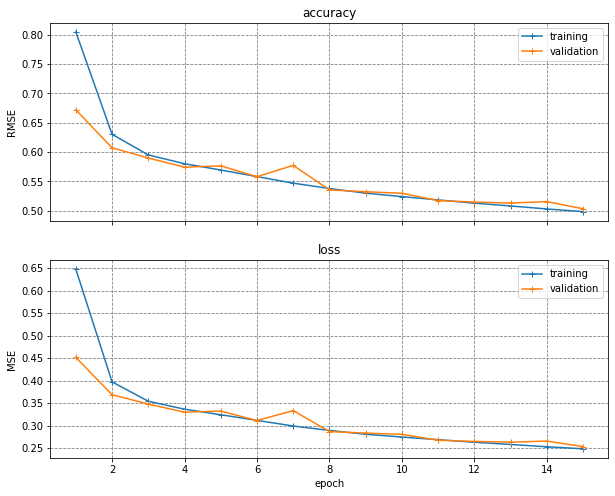

In [ ]:
acc = model_01_history.history['root_mean_squared_error']
val_acc = model_01_history.history['val_root_mean_squared_error']

loss = model_01_history.history['loss']
val_loss = model_01_history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, EPOCHS+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('RMSE')
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('MSE')
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

In [ ]:
def plot_monthly_prediction(time_ax, diff_ax, history, target, prediction):
    """
    Parameters
    ----------
    time_ax : axis
        The axis on which to plot the time series

    diff_ax : axis
        The axis on which to plot the difference between the prediction and target

    history : array_like
        The history window.

    target : array_like
        The target window.

    prediction : array_like
        The model prediction of the target window.
    """
    # make x=0 the start of the target window
    history_x = np.arange(-len(history), 0)
    target_x = np.arange(len(target))
    # plot the history window
    time_ax.plot(history_x,
                 np.array(history[:, 2])*data_std[2]+data_mean[2],
                 c='C7', label='history')

    # plot the connection between the history window and the target window
    time_ax.plot([history_x[-1],target_x[0]],
                 np.array([np.array(history[:, 2])[-1], np.array(target)[0]])*data_std[2]+data_mean[2],
                 c='k', ls='--', label='__nolegend__')

    # plot the target window
    time_ax.plot(target_x,
                 np.array(target)*data_std[2]+data_mean[2],
                 c='k', label='target')

    # plot the connection between the history window and the prediction window
    time_ax.plot([history_x[-1],target_x[0]],
                 np.array([np.array(history[:, 2])[-1], np.array(prediction)[0]])*data_std[2]+data_mean[2],
                 c='r', ls='--', label='__nolegend__')

    # plot the prediction window
    time_ax.plot(target_x,
                 np.array(prediction)*data_std[2]+data_mean[2],
                 c='r', label='prediction')

    # plot the difference
    diff_ax.plot(target_x,
                 (np.array(prediction)-np.array(target))*data_std[2],
                 c='r')
    diff_ax.axhline(0, ls='--', c='C7')

8/8 [==============================] - 0s 39ms/step


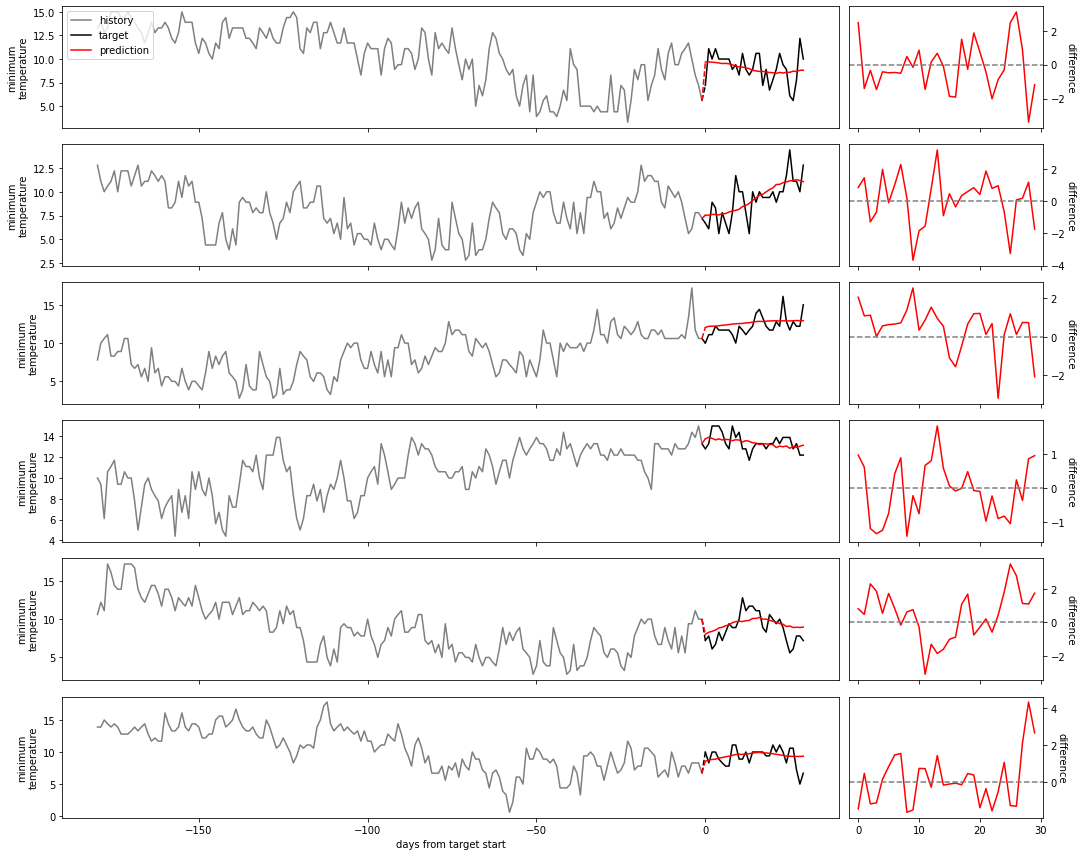

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15,12), sharex='col', gridspec_kw={'width_ratios':[1,0.25]})

np.random.seed(22)
i = 0

# take a batch
for x, y in val_data.take(6):

    # get an instance within that batch
    rand_ind = np.random.choice(np.arange(x.shape[0]), size=1)[0]

    # predict and plot
    plot_monthly_prediction(ax[i][0], ax[i][1], x[rand_ind], y[rand_ind], model_01.predict(x)[rand_ind])
    ax[i][0].set_ylabel('minimum\ntemperature')
    ax[i][1].yaxis.tick_right()
    ax[i][1].yaxis.set_label_position('right')
    ax[i][1].set_ylabel('difference', rotation=270, labelpad=10)
    i = i + 1

ax[0][0].legend(loc='upper left')
ax[5][0].set_xlabel('days from target start')

fig.tight_layout()
plt.show(fig)

2/2 [==============================] - 0s 30ms/step


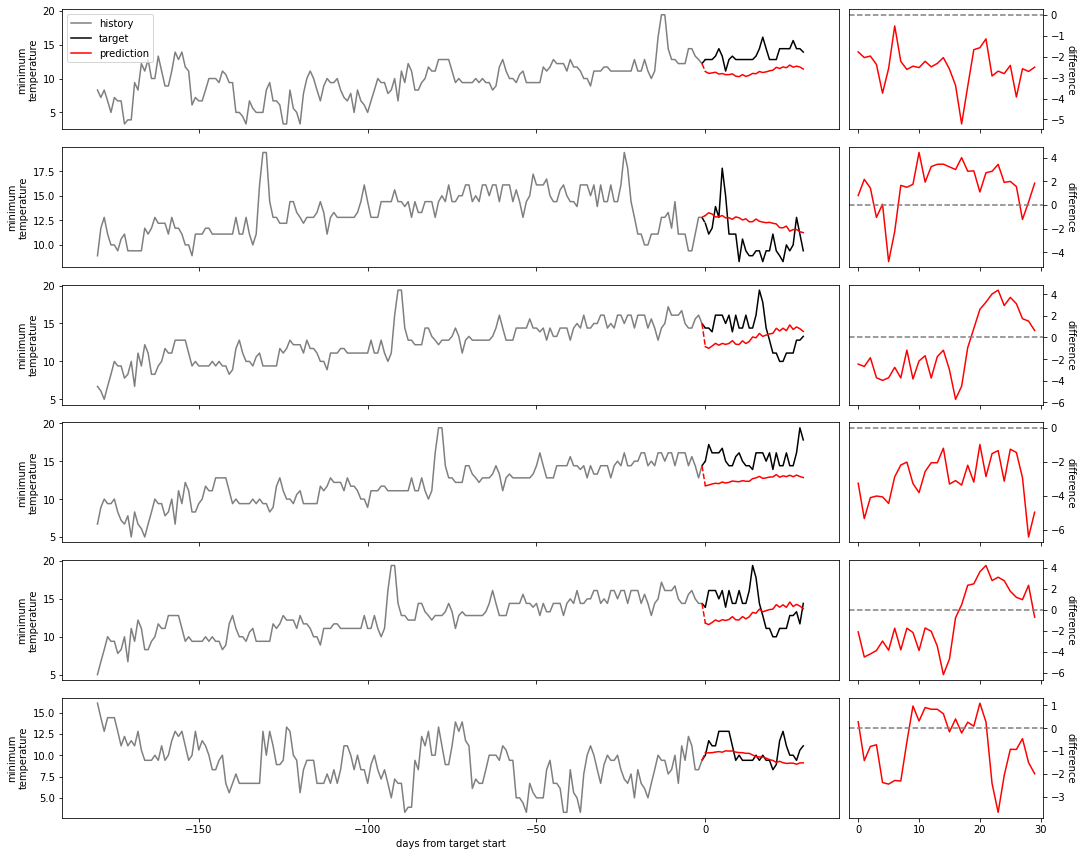

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15,12), sharex='col', gridspec_kw={'width_ratios':[1,0.25]})

np.random.seed(22)
i = 0

# take a batch
for x, y in test_data.take(6):

    # get an instance within that batch
    rand_ind = np.random.choice(np.arange(x.shape[0]), size=1)[0]

    # predict and plot
    plot_monthly_prediction(ax[i][0], ax[i][1], x[rand_ind], y[rand_ind], model_01.predict(x)[rand_ind])
    ax[i][0].set_ylabel('minimum\ntemperature')
    ax[i][1].yaxis.tick_right()
    ax[i][1].yaxis.set_label_position('right')
    ax[i][1].set_ylabel('difference', rotation=270, labelpad=10)
    i = i + 1

ax[0][0].legend(loc='upper left')
ax[5][0].set_xlabel('days from target start')

fig.tight_layout()
plt.show(fig)

In [ ]:
# define window sizes
history_size = 180
target_size = 1

# define the split sizes
TRAIN_SPLIT = 7000
VAL_SPLIT = 1000
TEST_SPLIT = n_instances - TRAIN_SPLIT - VAL_SPLIT - history_size - target_size

# extract the test split
x_test, y_test = multivariate_data(dataset, dataset[:, 2], n_instances-target_size-TEST_SPLIT, n_instances-target_size, history_size, target_size)

# extract the x and y that has to be shuffled
x_shuffle, y_shuffle = multivariate_data(dataset, dataset[:, 2], history_size, n_instances-target_size-TEST_SPLIT, history_size, target_size)

# shuffle
p = np.random.permutation(x_shuffle.shape[0])
x_shuffle = x_shuffle[p]
y_shuffle = y_shuffle[p]

# make the train/validation split
x_train = x_shuffle[:TRAIN_SPLIT,:,:]
x_val = x_shuffle[TRAIN_SPLIT:,:,:]
y_train = y_shuffle[:TRAIN_SPLIT,:]
y_val = y_shuffle[TRAIN_SPLIT:,:]

print('x_train  = {}'.format(x_train.shape))
print('x_val    = {}'.format(x_val.shape))
print('x_test   = {}'.format(x_test.shape))

x_train  = (7000, 180, 10)
x_val    = (1000, 180, 10)
x_test   = (319, 180, 10)


In [ ]:
print('Single history window : {}'.format(x_train[0].shape))
print('Single target window  : {}'.format(y_train[0].shape))

Single history window : (180, 10)
Single target window  : (1,)


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE).repeat()

In [ ]:
model_02 = tf.keras.models.Sequential()

model_02.add(tf.keras.layers.LSTM(32, input_shape=x_train.shape[-2:], return_sequences=True))
model_02.add(tf.keras.layers.LSTM(8, activation='relu'))
model_02.add(tf.keras.layers.Dense(target_size))

model_02.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
                 loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 180, 32)           5504      
                                                                 
 lstm_4 (LSTM)               (None, 8)                 1312      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,825
Trainable params: 6,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 7

model_02_history = model_02.fit(train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=50)

Epoch 1/7
200/200 [==============================] - 52s 244ms/step - loss: 0.3080 - root_mean_squared_error: 0.5549 - val_loss: 0.2333 - val_root_mean_squared_error: 0.4830
Epoch 2/7
200/200 [==============================] - 49s 243ms/step - loss: 0.2012 - root_mean_squared_error: 0.4485 - val_loss: 0.2016 - val_root_mean_squared_error: 0.4490
Epoch 3/7
200/200 [==============================] - 50s 248ms/step - loss: 0.1811 - root_mean_squared_error: 0.4255 - val_loss: 0.1891 - val_root_mean_squared_error: 0.4348
Epoch 4/7
200/200 [==============================] - 52s 259ms/step - loss: 0.1740 - root_mean_squared_error: 0.4171 - val_loss: 0.1965 - val_root_mean_squared_error: 0.4433
Epoch 5/7
200/200 [==============================] - 52s 262ms/step - loss: 0.1687 - root_mean_squared_error: 0.4107 - val_loss: 0.1855 - val_root_mean_squared_error: 0.4307
Epoch 6/7
200/200 [==============================] - 51s 254ms/step - loss: 0.1640 - root_mean_squared_error: 0.4050 - val_loss: 0

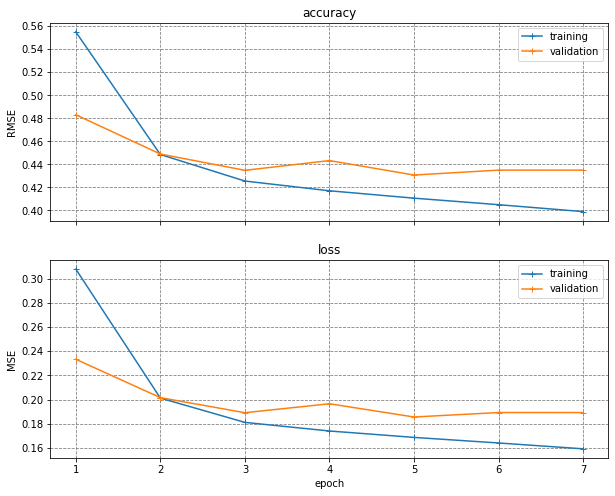

In [ ]:
acc = model_02_history.history['root_mean_squared_error']
val_acc = model_02_history.history['val_root_mean_squared_error']

loss = model_02_history.history['loss']
val_loss = model_02_history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, EPOCHS+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('RMSE')
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('MSE')
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

In [ ]:
def plot_daily_prediction(time_ax, diff_ax, history, target, start_index, n_repeats, x_split, y_split):
    """
    Parameters
    ----------
    time_ax : axis
        The axis on which to plot the time series

    diff_ax : axis
        The axis on which to plot the difference between the prediction and target

    history : array_like
        The history window.

    target : array_like
        The target window.

    start_index : int
        The index at which to start making predictions.

    n_repeats : int
        The number of repeat predictions to make.

    x_split : array_like
        The array with the x data.

    y_split : array_like
        The array with the y data.
    """
    repeated_predictions = []
    repeated_target = []
# iterate the appropriate number of times
    for i in range(n_repeats):

        # make the prediction and store results
        prediction = model_02.predict(x_split[start_index+i])
        repeated_predictions.append(prediction[0][0])

        # keep track of the target
        repeated_target.append(y_split[start_index+i][0][0])

    repeated_predictions = np.array(repeated_predictions)
    repeated_target = np.array(repeated_target)

    # make x=0 the start of the target window
    history_x = np.arange(-history.shape[1], 0)
    target_x = np.arange(len(repeated_target))

    # plot the history window
    time_ax.plot(history_x,
                 history[0,:,2]*data_std[2]+data_mean[2],
                 c='C7', label='history')

    # plot the connection between the history window and the target window
    time_ax.plot([history_x[-1],target_x[0]],
                 np.array([history[0,:,2][-1], repeated_target[0]])*data_std[2]+data_mean[2],
                 c='k', ls='--', label='__nolegend__')

    # plot the target window
    time_ax.plot(target_x,
                 repeated_target*data_std[2]+data_mean[2],
                 c='k', label='target')
    # plot the connection between the history window and the prediction window
    time_ax.plot([history_x[-1],target_x[0]],
                 np.array([history[0,:,2][-1], repeated_predictions[0]])*data_std[2]+data_mean[2],
                 c='r', ls='--', label='__nolegend__')

    # plot the prediction window
    time_ax.plot(target_x,
                 repeated_predictions*data_std[2]+data_mean[2],
                 c='r', label='prediction')

    # plot the difference
    diff_ax.plot(target_x,
                 (repeated_predictions-repeated_target)*data_std[2],
                 c='r')
    diff_ax.axhline(0, ls='--', c='C7')

In [ ]:
# where the train/validation data came from, but this time unshuffled
x_unshuffled, y_unshuffled = multivariate_data(dataset, dataset[:, 2], history_size, n_instances-target_size-TEST_SPLIT, history_size, target_size)

1/1 [==============================] - 0s 30ms/step


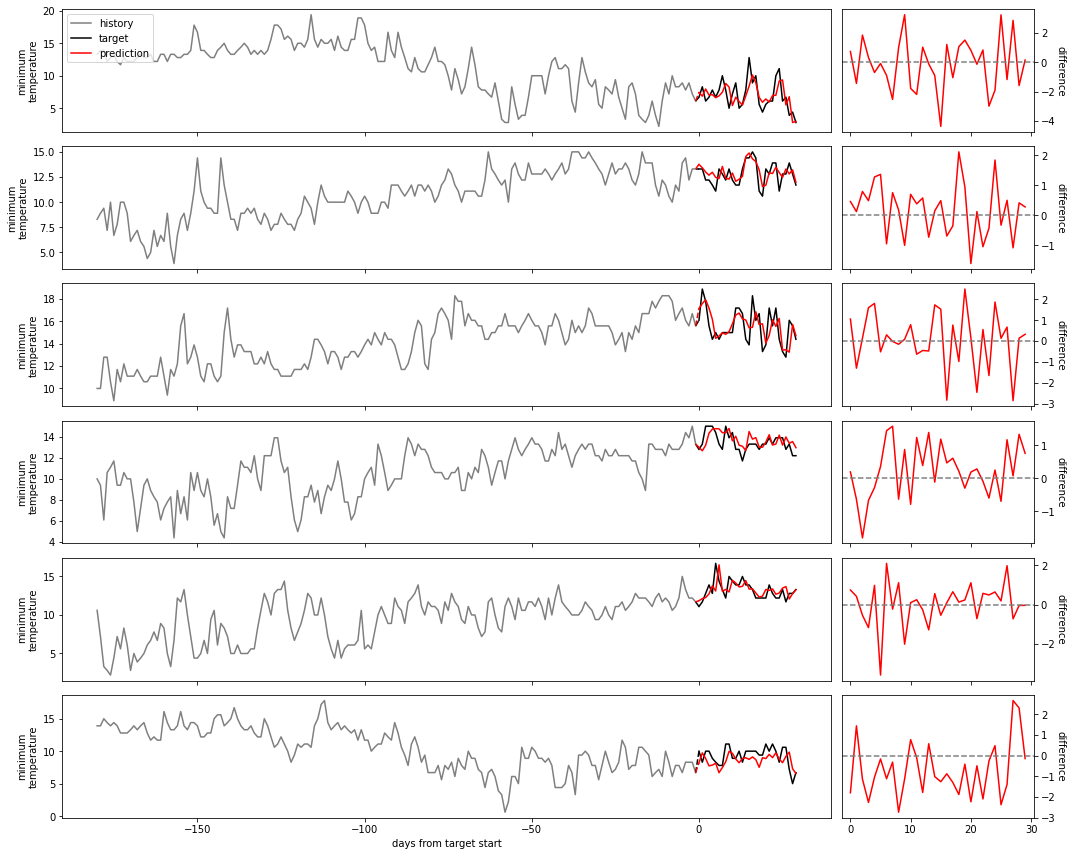

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15,12), sharex='col', gridspec_kw={'width_ratios':[1,0.25]})

np.random.seed(22)

for i in range(6):

    # get an instance from the validation split
    rand_ind = np.random.choice(p[TRAIN_SPLIT:], size=1)

    # check to make sure that there's room to predict a month after the instance
    while rand_ind > len(x_unshuffled)-30:
        rand_ind = np.random.choice(p[TRAIN_SPLIT:], size=1)

    # predict and plot
    plot_daily_prediction(ax[i][0], ax[i][1], x_unshuffled[rand_ind], y_unshuffled[rand_ind], rand_ind, 30, x_unshuffled, y_unshuffled)
    ax[i][0].set_ylabel('minimum\ntemperature')
    ax[i][1].yaxis.tick_right()
    ax[i][1].yaxis.set_label_position('right')
    ax[i][1].set_ylabel('difference', rotation=270, labelpad=10)
    i = i + 1

ax[0][0].legend(loc='upper left')
ax[5][0].set_xlabel('days from target start')

fig.tight_layout()
plt.show(fig)

1/1 [==============================] - 0s 27ms/step


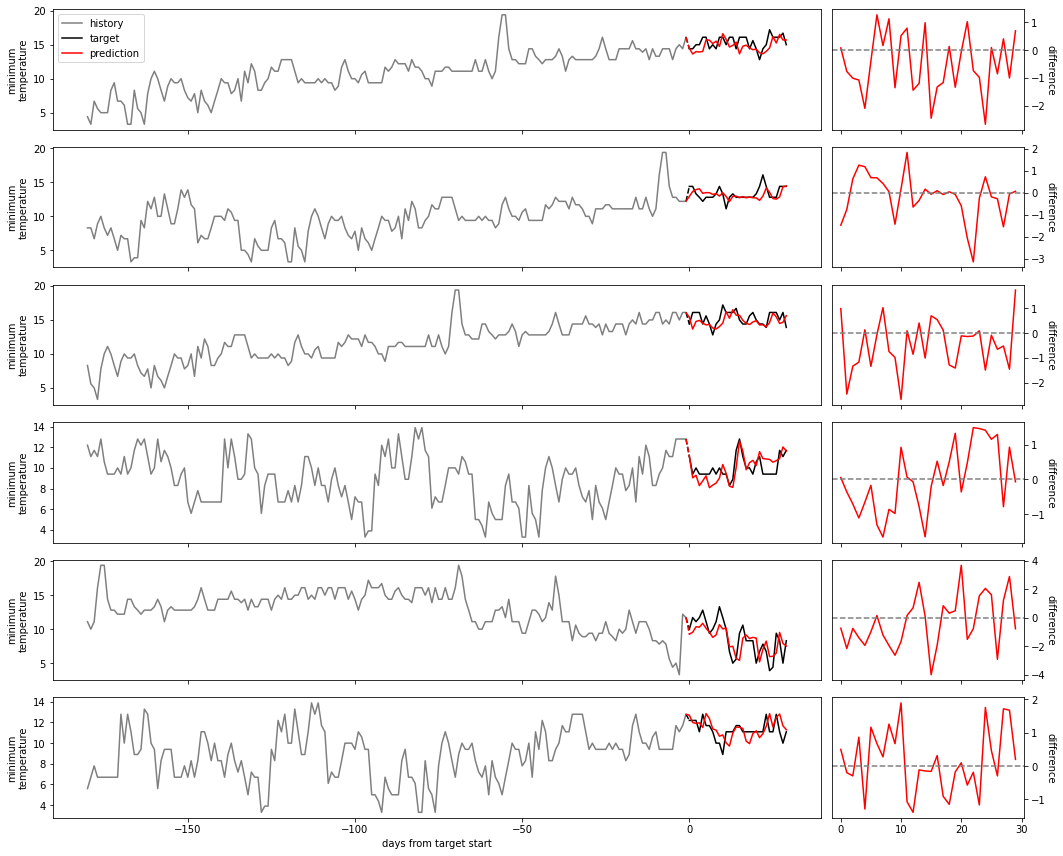

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15,12), sharex='col', gridspec_kw={'width_ratios':[1,0.25]})

np.random.seed(22)

for i in range(6):

    # get an instance from the test split
    rand_ind = np.random.choice(np.arange(len(x_test)-30), size=1)

    # predict and plot
    plot_daily_prediction(ax[i][0], ax[i][1], x_test[rand_ind], y_test[rand_ind], rand_ind, 30, x_test, y_test)
    ax[i][0].set_ylabel('minimum\ntemperature')
    ax[i][1].yaxis.tick_right()
    ax[i][1].yaxis.set_label_position('right')
    ax[i][1].set_ylabel('difference', rotation=270, labelpad=10)
    i = i + 1

ax[0][0].legend(loc='upper left')
ax[5][0].set_xlabel('days from target start')

fig.tight_layout()
plt.show(fig)

In [ ]:
def plot_both_prediction(time_ax, diff_ax, start_index, x_split, y_split):
    """
    Parameters
    ----------
    time_ax : axis
        The axis on which to plot the time series

    diff_ax : axis
        The axis on which to plot the difference between the prediction and target

    history : array_like
        The history window.

    target : array_like
        The target window.

    prediction : array_like
        The model prediction of the target window.
    """
    ## THE MONTHLY PREDICTION
    single_predictions = model_01.predict(x_split[start_index])

    ## THE DAILY PREDICTION
    repeated_predictions = []
    repeated_target = []
    # iterate the appropriate number of times
    for i in range(30):

        # make the prediction and store results
        prediction = model_02.predict(x_split[start_index+i])
        repeated_predictions.append(prediction[0][0])

        # keep track of the target
        repeated_target.append(y_split[start_index+i][0][0])

    repeated_predictions = np.array(repeated_predictions)
    repeated_target = np.array(repeated_target)

    ## PLOTTING

    # make x=0 the start of the target window
    history_x = np.arange(-x_split[start_index].shape[1], 0)
    target_x = np.arange(len(repeated_target))

    # plot the history window
    time_ax.plot(history_x,
                 x_split[start_index][0,:,2]*data_std[2]+data_mean[2],
                 c='C7', label='history')

    # plot the connection between the history window and the target window
    time_ax.plot([history_x[-1],target_x[0]],
                 np.array([x_split[start_index][0,:,2][-1], repeated_target[0]])*data_std[2]+data_mean[2],
                 c='k', ls='--', label='__nolegend__')

    # plot the target window
    time_ax.plot(target_x,
                 repeated_target*data_std[2]+data_mean[2],
                 c='k', label='target')

    # plot the connection between the history window and the prediction window
    time_ax.plot([history_x[-1],target_x[0]],
                 np.array([x_split[start_index][0,:,2][-1], single_predictions[0,0]])*data_std[2]+data_mean[2],
                 c='C0', ls='--', label='__nolegend__')
    # plot the prediction window
    time_ax.plot(target_x,
                 single_predictions[0]*data_std[2]+data_mean[2],
                 c='C0', label='monthly prediction')

    # plot the connection between the history window and the prediction window
    time_ax.plot([history_x[-1],target_x[0]],
                 np.array([x_split[start_index][0,:,2][-1], repeated_predictions[0]])*data_std[2]+data_mean[2],
                 c='C1', ls='--', label='__nolegend__')

    # plot the prediction window
    time_ax.plot(target_x,
                 repeated_predictions*data_std[2]+data_mean[2],
                 c='C1', label='daily prediction')

    # plot the differences
    diff_ax.plot(target_x,
                 (single_predictions[0]-repeated_target)*data_std[2],
                 c='C0')
    diff_ax.plot(target_x,
                 (repeated_predictions-repeated_target)*data_std[2],
                 c='C1')
    diff_ax.axhline(0, ls='--', c='C7')

1/1 [==============================] - 0s 28ms/step


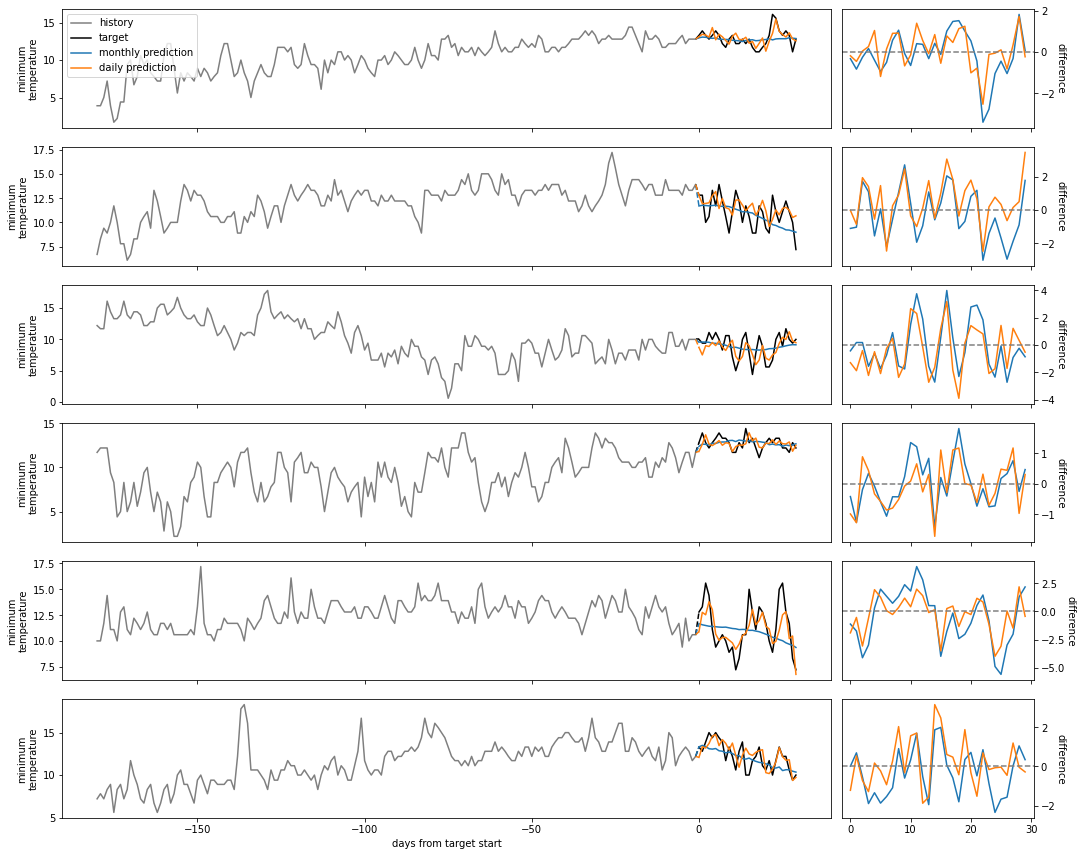

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15,12), sharex='col', gridspec_kw={'width_ratios':[1,0.25]})

np.random.seed(22)

for i in range(6):

    # get an instance from the validation split
    rand_ind = np.random.choice(p[TRAIN_SPLIT:], size=1)

    # check to make sure that there's room to predict a month after the instance
    while rand_ind > len(x_unshuffled)-30:
        rand_ind = np.random.choice(p[TRAIN_SPLIT:], size=1)

    # predict and plot
    plot_both_prediction(ax[i][0], ax[i][1], rand_ind, x_unshuffled, y_unshuffled)
    ax[i][0].set_ylabel('minimum\ntemperature')
    ax[i][1].yaxis.tick_right()
    ax[i][1].yaxis.set_label_position('right')
    ax[i][1].set_ylabel('difference', rotation=270, labelpad=10)
    i = i + 1

ax[0][0].legend(loc='upper left')
ax[5][0].set_xlabel('days from target start')

fig.tight_layout()
plt.show(fig)

1/1 [==============================] - 0s 31ms/step


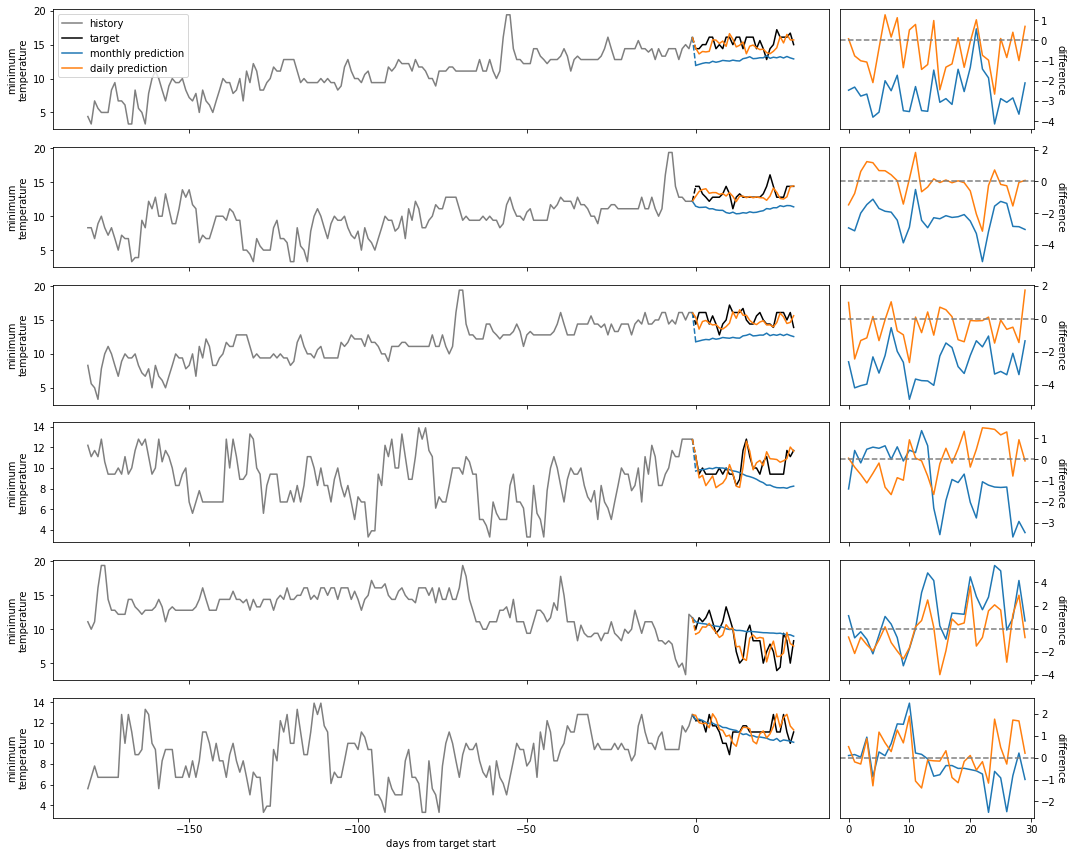

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15,12), sharex='col', gridspec_kw={'width_ratios':[1,0.25]})

np.random.seed(22)

for i in range(6):

    # get an instance from the test split
    rand_ind = np.random.choice(np.arange(len(x_test)-30), size=1)

    # predict and plot
    plot_both_prediction(ax[i][0], ax[i][1], rand_ind, x_test, y_test)
    ax[i][0].set_ylabel('minimum\ntemperature')
    ax[i][1].yaxis.tick_right()
    ax[i][1].yaxis.set_label_position('right')
    ax[i][1].set_ylabel('difference', rotation=270, labelpad=10)
    i = i + 1

ax[0][0].legend(loc='upper left')
ax[5][0].set_xlabel('days from target start')

fig.tight_layout()
plt.show(fig)